# Notebook Setup

Markdown comments = thoughts on high-level, project-management-esque decisions

`# Inline or cell-blocked code comments = thoughts on low-level, coding/optimization decisions `

In [26]:
# Imports
import sys
sys.path.append("../modules/")
import imports
import helper
import eda

# To see a full list of my imports, functions, and global variables, see ../modules/ folder

In [27]:
# Loading data
filename = "twitter_parsed_dataset"
filepath = f"{imports.DEV_PATH_TO_RAW_DATA}/{filename}.csv"
twitter_df = imports.pd.read_csv(filepath)

# filename = "QAnon-posts"
# filepath = f"{imports.DEV_PATH_TO_RAW_DATA}/{filename}.json"
# qanon_df = imports.pd.read_json(filepath)

# EDA

## Data Cleaning

I am going to first clean the data to make sure it is ready for use. This includes things like checking for wrong inputs, formats, duplicates, etc.

In [28]:
# Looking at data of first df
print(twitter_df.columns)
twitter_df.head(5)

Index(['index', 'id', 'Text', 'Annotation', 'oh_label'], dtype='object')


,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0


In [29]:
# Checking for wrong data formats
twitter_df.dtypes

index          object
id             object
Text           object
Annotation     object
oh_label      float64
dtype: object

In [30]:
# text and annotation set to the new Pandas string format
twitter_df["Text"] = twitter_df["Text"].astype("string")
twitter_df["Annotation"] = twitter_df["Annotation"].astype("string")
twitter_df["oh_label"] = twitter_df["oh_label"].astype("bool")
twitter_df.dtypes

index                 object
id                    object
Text          string[python]
Annotation    string[python]
oh_label                bool
dtype: object

In [31]:
# Checking for potential typos/bad inputs and class distribution
# Not checking first three columns since would return unique values
eda.check_values_perc(twitter_df.loc[:, twitter_df.columns[3:]])

Annotation
none      0.682633
sexism    0.200439
racism    0.116928
Name: proportion, dtype: Float64

['none', 'sexism', 'racism', <NA>]
---------
oh_label
False    0.682511
True     0.317489
Name: proportion, dtype: float64

[False, True]
---------


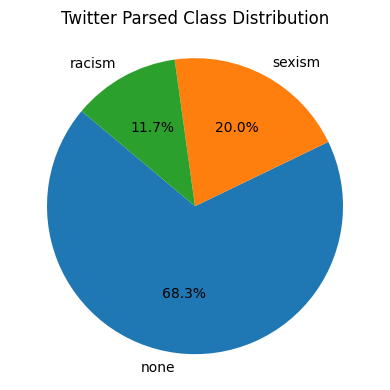

In [32]:
# Visualizing class imbalance with ad hoc pie chart

# Datasetup
pie_values = twitter_df["Annotation"].value_counts(normalize=True)

# Pre-Graph Formatting
imports.plt.figure(figsize=imports.DEFAULT_SQUARE_FIG_SIZE)
imports.plt.title("Twitter Parsed Class Distribution")
imports.plt.axis("equal")

# Graphing
imports.plt.pie(pie_values.tolist(), labels=pie_values.index.tolist(), autopct="%1.1f%%", startangle=140)

# Post-Graph Processing
imports.plt.tight_layout()
filepath = f"{imports.DEV_PATH_TO_EDA}/pie_chart_class_imbalance.png"
imports.plt.savefig(filepath)
imports.plt.show()

In [33]:
# Checking for missing values
eda.check_missing_nan(twitter_df)

,id,Text,Annotation
2992,5.67909969783169E+017,RT @Lizzethismetal: Probably gonna piss off so...,<NA>
2993,NaN,<NA>,<NA>
2994,sexism,1,<NA>


In [34]:
# One of the rows was improperly formatted; it spreads across 3 rows when it should just be one
twitter_df.iloc[2992:2995]

,index,id,Text,Annotation,oh_label
2992,5.67909969783169E+017,5.67909969783169E+017,RT @Lizzethismetal: Probably gonna piss off so...,<NA>,True
2993,#yesallmen,NaN,<NA>,<NA>,True
2994,@MT8_9 http://t.co/QHo6dhumjc,sexism,1,<NA>,True


In [35]:
# Re-combining the text values in 2992 row's Text, refilling 2992 row's Annotation with the proper value, and deleting 2993 and 2994
twitter_df.iloc[2992, twitter_df.columns.get_loc("Text")] = twitter_df.iloc[2992]["Text"] + twitter_df.iloc[2993]["index"] + twitter_df.iloc[2994]["index"]
twitter_df.iloc[2992, twitter_df.columns.get_loc("Annotation")] = twitter_df.iloc[2994]["id"]
twitter_df.drop([2993, 2994], inplace=True)
twitter_df.iloc[2992]

index                                     5.67909969783169E+017
id                                        5.67909969783169E+017
Text          RT @Lizzethismetal: Probably gonna piss off so...
Annotation                                               sexism
oh_label                                                   True
Name: 2992, dtype: object

In [36]:
# Checking for duplicate values via the "Text" column for more fine-combed approach
dupe_series = twitter_df["Text"].duplicated()
dupe_series[dupe_series == "True"]

Series([], Name: Text, dtype: bool)

In [37]:
# Dropping unnecessary columns, renaming columns for better clarity
twitter_df.drop(["index", "id"], axis=1, inplace=True)
twitter_df.rename(columns={"Annotation": "Class", "oh_label": "Cyberbullying"}, inplace=True)
twitter_df.head(1)

,Text,Class,Cyberbullying
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,False


In [38]:
# Database is prepped
twitter_df.head(5)

,Text,Class,Cyberbullying
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,False
1,@ShreyaBafna3 Now you idiots claim that people...,none,False
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,True
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,True
4,#mkr No No No No No No,none,False


In [39]:
# Save dataframe
filename = "twitter_cleaned"
filepath = f"{imports.DEV_PATH_TO_PREPPED_DATA}/{filename}.csv"
twitter_df.to_csv(filepath, index=False)

## Data Preprocessing & Feature Engineering

At this point, I want to touch-up the text data to make future NLP processing more efficient.

General NLP Formatting
- convert text to lowercase
- remove stopwords
- stem words
- remove punctation/special characters

Context-Specific Formatting
- remove "RT" (retweet) tag
- remove URLs
- remove the Twitter handles taggings like @username
- remove hashtag tags

I acknowledge that some of actions will impact feature engineering later on (e.g. deriving a "word count" column on the text pre-vs-post stopwords removal). As a middle-ground for now, I will create new features in the dataset to account for these changes (e.g. even though I am removing all URLs, I will create a dataset column on whether a URL was used in the datapoint). Since the dataset is a little small, I want to derive a few more new features that may potentially improve the model. I will create the new columns:

- word count
- sentiment analysis score

along with the boolean columns above.

I am just starting with these steps to demonstrate a "proof-of-concept" approach, and this method is flexible to adjustment depending on more context-specific research and/or supervisor input. (E.g. how to handle non-English text given the project's context in understanding cyberbullying.)

In [40]:
# Load in data
df = imports.pd.read_csv(filepath)
df.head(1)

,Text,Class,Cyberbullying
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,False


In [41]:
# Removing stopwords, URLs, emojis, handles, etc.
# Creating engineering new columns to match the removed data
lemmatizer = imports.nltk.WordNetLemmatizer() # initialize lemmatizer
stop_words = set(imports.stopwords.words("english")) # skip LazyCorpusLoader
bool_features = [[], [], [], []] # retweet, url, mention, hastag
nonbool_features = [[], [], []] # topics, word count, sentiment score
filtered_text = []

for text_row in df["Text"]:
    bool_list = [0,0,0,0] # retweet, url, mention, hastag bools
    filtered_row = []
    topics_row = []

    # Fixing typo errors of the kind ("end.Start" -> "end. Start") to ensure proper word parsing
    words_split = text_row.split()
    new_words_split = []
    for word in words_split:
        if not word.startswith("http") and not word.startswith("@") and not word.startswith("#"): # if the word isn't an URL, mention, or hashtag
            for sub_word in word.replace(".", ". ").replace("-", " ").split(" "):
                new_words_split.append(sub_word.strip())
        else:
            new_words_split.append(word.strip())

    for word in new_words_split:
        is_removed = False
        # Checking if empty string or whitespace
        if word == "" or word.isspace():
            continue

        # Checking if text_row has retweet, url, mention, or hashtag
        if word == "RT":
            bool_list[0] = 1
            is_removed = True
        if word.startswith("http"):
            bool_list[1] = 1
            is_removed = True
        if word.startswith("@"):
            bool_list[2] = 1
            is_removed = True
        if word.startswith("#"):
            bool_list[3] = 1
            topics_row.append(word[1:].lower()) # appending the hashtag to topic column
            is_removed = True
        
        # Checking if stopword
        if word.lower() in stop_words: # since stopwords are all lowercase
            is_removed = True

        # De-punctuation, lowercase, and lemma any words kept
        if is_removed == False:
            if word.isupper() and len(word) >= 2: # ignoring acronyms
                filtered_word = word
            else:
                filtered_word = word.lower()
                for char in imports.CHARS_TO_REMOVE:
                    filtered_word = filtered_word.replace(char, "")
                filtered_word = lemmatizer.lemmatize(filtered_word)
            if filtered_word == "" or word.isspace():
                continue 
            else:
                filtered_row.append(filtered_word)

    # Create filtered results
    filtered_row_connect = " ".join(filtered_row)
    filtered_text.append(filtered_row_connect)
    nonbool_list = [", ".join(topics_row), len(filtered_row), helper.extract_sentiment_score(filtered_row_connect)]
    for i in range(len(bool_features)): # bool series creation
        bool_features[i].append(bool_list[i])
    for i in range(len(nonbool_features)): # nonbool series creation
        nonbool_features[i].append(nonbool_list[i])

# Overwrite old df with new filtered results
df["Raw Text"] = filtered_text
df["Text"] = df["Raw Text"].apply(helper.remove_emoji)
bool_column_names = ["Retweet", "URL", "Mention", "Hashtag"]
for i in range(len(bool_column_names)):
    df[bool_column_names[i]] = bool_features[i]
nonbool_column_names = ["Topics", "Word Count", "Sentiment Score"]
for i in range(len(nonbool_column_names)):
    df[nonbool_column_names[i]] = nonbool_features[i]

In [42]:
# Converting class to numeric values
def class_mapper(text):
    if text == "none":
        return 1
    elif text == "sexism":
        return 2
    else:
        return 3
    
df["Mapped Class"] = df["Class"].apply(class_mapper)

In [43]:
# Reordering columns
df = df[["Text", "Topics", "Retweet", "URL", "Mention", "Hashtag", "Word Count", "Sentiment Score", "Cyberbullying", "Class", "Mapped Class"]]
df.head(10)

,Text,Topics,Retweet,URL,Mention,Hashtag,Word Count,Sentiment Score,Cyberbullying,Class,Mapped Class
0,read context change meaning history islamic sl...,,0,1,1,0,7,-0.7003,False,none,1
1,idiot claim people tried stop becoming terrori...,,0,0,1,0,12,-0.9648,False,none,1
2,call sexist go auto place id rather talk guy,,1,0,1,0,9,0.0000,True,sexism,2
3,wrong ISIS follows example mohammed quran exactly,,0,0,1,0,7,-0.4767,True,racism,3
4,,mkr,0,0,0,1,0,0.0000,False,none,1
5,saudi preacher raped tortured five year old da...,,1,1,1,0,11,-0.9201,False,none,1
6,nooo sexist woman bad driver,,1,0,1,0,5,-0.5423,True,sexism,2
7,going make pancake hve strawberry but hve banana,mkr,0,0,0,1,9,0.0000,False,none,1
8,dare feeling fantastic way dehumanize someone,,1,0,1,0,6,0.3182,False,none,1
9,there something wrong girl win wayne rooney st...,notsexist,1,0,1,1,9,0.1779,True,sexism,2


In [44]:
# Save dataframe
filename = "twitter_preprocessed"
filepath = f"{imports.DEV_PATH_TO_PREPPED_DATA}/{filename}.csv"
df.to_csv(filepath, index=False)

## Visualizations

Exploring the cleaned data to get better understanding of its shape. This would be useful for determining preprocessing steps (e.g. scaling).

In [45]:
# Define custom function for convenience
def quick_look(series, label):
    eda.graph_histogram(series, label)
    eda.graph_boxplot(series, label)
    return eda.graph_description(series, label)

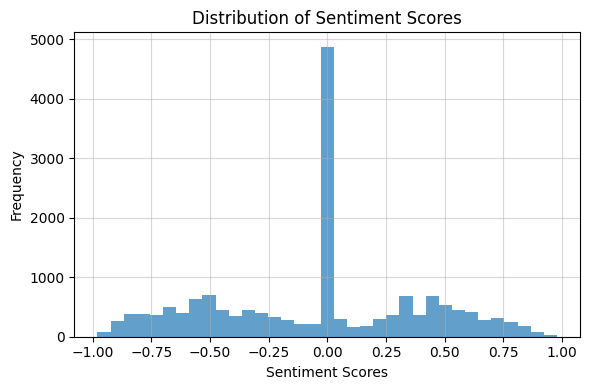

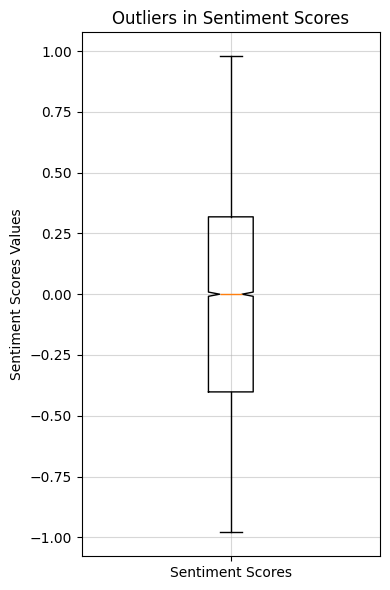

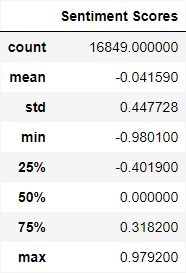

In [46]:
quick_look(df["Sentiment Score"], "Sentiment Scores")

Sentiment scores are to be expected, considering the class distribution we saw before. The majority of the posts are "none" (so neither sexist nor racist), and intuitively these feel like closer to neutral statements with sentiments of 0.00. 

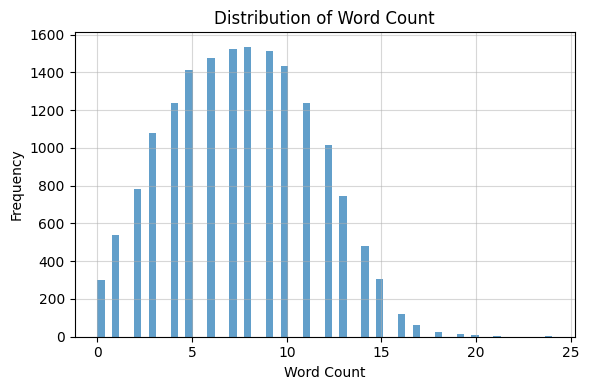

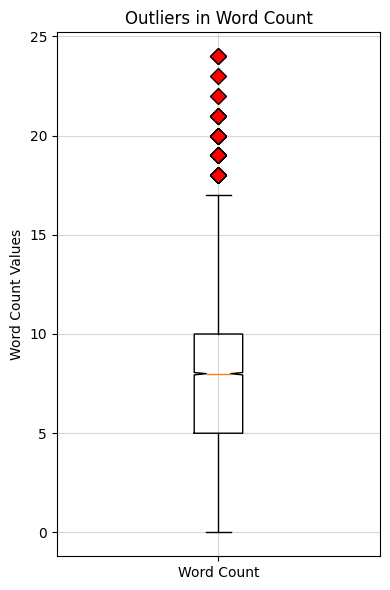

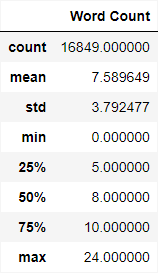

In [47]:
quick_look(df["Word Count"], "Word Count")

Word count follows an approxiamately normal distribution, with a slight right-tailed skew. Note: word count was calculated after tokenization, meaning the word count more so accurately counts the "units of meaning" rather than filler words.

For example, "Yo, today is so so so hot" (7 words) vs. "Today so hot" (3 words)

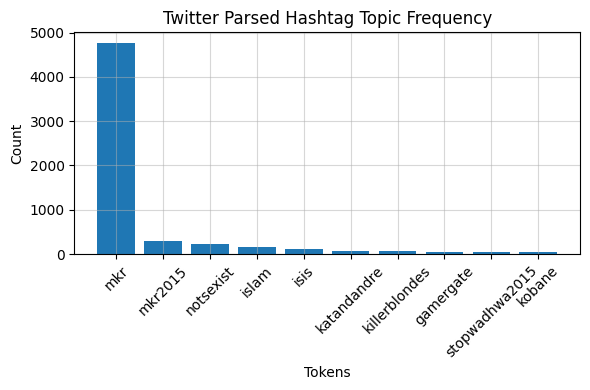

In [48]:
# Visualizing frequency of topics with ad hoc bar chart

# Extract frequencies
topics_series = df["Topics"].replace('', imports.pd.NA).dropna()
freq_topics = {}
for text_row in topics_series:
    for word in text_row.split(", "):
        if word in freq_topics.keys():
            freq_topics[word] += 1
        else:
            freq_topics[word] = 1

# Sort values
n = 10
sorted_freq = {k: v for k, v in sorted(freq_topics.items(), key=lambda x: x[1], reverse=True)}
sorted_keys = list(sorted_freq.keys())[:n]
sorted_values = list(sorted_freq.values())[:n]

# Pre-Graph Formatting
imports.plt.figure(figsize=imports.DEFAULT_LONG_FIG_SIZE)
imports.plt.title("Twitter Parsed Hashtag Topic Frequency")
imports.plt.xlabel("Tokens")
imports.plt.xticks(rotation=45)
imports.plt.ylabel("Count")
imports.plt.grid("True", alpha=imports.DEFAULT_GRID_ALPHA)

# Graphing
imports.plt.bar(sorted_keys, sorted_values)

# Post-Graph Processing
imports.plt.tight_layout()
filepath = f"{imports.DEV_PATH_TO_EDA}/topic_frequency.png"
imports.plt.savefig(filepath)
imports.plt.show()

I believe MKR stands for My Kitchen Rules, which is a TV series. In 2014, Season 5 of MKR received criticism for seemingly tolerating (even promoting) bullying behaviour on the show by allowing a seemingly antagonstic team become runner-up. My guess is that a number of tweets are call-to-actions for a better 2015 season. 

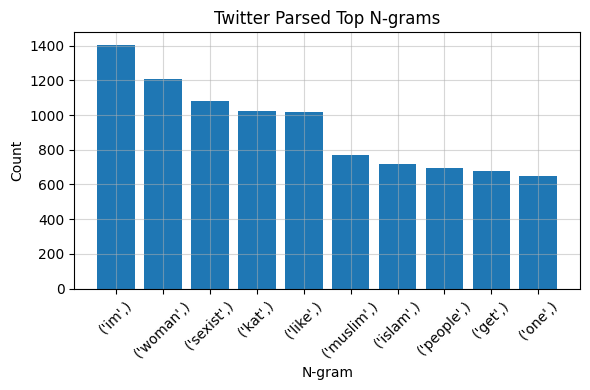

In [58]:
# Visualizing the top 1 to 3 n-grams with ad hoc bar

# Extracting n-grams
top_n = 10
top_1grams = helper.get_ngrams(df["Text"], 1)
top_2grams = helper.get_ngrams(df["Text"], 2)
top_3grams = helper.get_ngrams(df["Text"], 3)
combined_ngrams = {**top_1grams, **top_2grams, **top_3grams}
ngrams_df = imports.pd.DataFrame(list(combined_ngrams.items()), columns=["N-gram", "Frequency"])
ngrams_df = ngrams_df.sort_values(by="Frequency", ascending=False)[:top_n]

# Pre-Graph Formatting
imports.plt.figure(figsize=imports.DEFAULT_LONG_FIG_SIZE)
imports.plt.title("Twitter Parsed Top N-grams")
imports.plt.xlabel("N-gram")
imports.plt.xticks(rotation=45)
imports.plt.ylabel("Count")
imports.plt.grid("True", alpha=imports.DEFAULT_GRID_ALPHA)

# Graphing
imports.plt.bar(ngrams_df["N-gram"].astype(str)[:top_n], ngrams_df["Frequency"][:top_n])

# Post-Graph Processing
imports.plt.tight_layout()
filepath = f"{imports.DEV_PATH_TO_EDA}/text_ngram_frequency.png"
imports.plt.savefig(filepath)
imports.plt.show()